In [1]:
from scapy.all import *

In [2]:
packet = IP()/TCP()

Ether()/packet

<Ether  type=IPv4 |<IP  frag=0 proto=tcp |<TCP  |>>>

In [3]:
Ether()

<Ether  |>

In [4]:
ls(IP, verbose=True)

version    : BitField  (4 bits)                  = ('4')
ihl        : BitField  (4 bits)                  = ('None')
tos        : XByteField                          = ('0')
len        : ShortField                          = ('None')
id         : ShortField                          = ('1')
flags      : FlagsField                          = ('<Flag 0 ()>')
               MF, DF, evil
frag       : BitField  (13 bits)                 = ('0')
ttl        : ByteField                           = ('64')
proto      : ByteEnumField                       = ('0')
               ip: 0
               icmp: 1
               ggp: 3
               tcp: 6
               egp: 8
               pup: 12
               udp: 17
               hmp: 20
               xns_idp: 22
               rdp: 27
               ipv6: 41
               ipv6_route: 43
               ipv6_frag: 44
               esp: 50
               ah: 51
               ipv6_icmp: 58
               ipv6_nonxt: 59
               ipv6_opts: 

In [5]:
a=IP(ttl=10)

In [6]:
Ether()/IP()/TCP()

<Ether  type=IPv4 |<IP  frag=0 proto=tcp |<TCP  |>>>

In [7]:
a=IP(dst="www.slashdot.org/30")

In [8]:
a

<IP  dst=Net("www.slashdot.org/30") |>

In [9]:
[p for p in a]

[<IP  dst=104.18.29.84 |>,
 <IP  dst=104.18.29.85 |>,
 <IP  dst=104.18.29.86 |>,
 <IP  dst=104.18.29.87 |>]

In [10]:
b=IP(ttl=[1,2,(5,9)])

In [11]:
[p for p in IP(ttl=(1,5))/ICMP()]

[<IP  frag=0 ttl=1 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=2 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=3 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=4 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=5 proto=icmp |<ICMP  |>>]

In [12]:
sniff(count=2, prn=lambda p: p.summary())

Ether / IP / TCP 93.184.220.29:http > 192.168.0.2:50151 A / Padding
Ether / IP / TCP 192.168.0.2:50151 > 93.184.220.29:http A


<Sniffed: TCP:2 UDP:0 ICMP:0 Other:0>

In [13]:
p = Ether()/IP(dst="www.secdev.org")/TCP()
p.summary()

'Ether / IP / TCP 192.168.0.2:ftp_data > Net("www.secdev.org/32"):http S'

In [14]:
print(p.dst)  # first layer that has an src field, here Ether
print(p[IP].src)  # explicitly access the src field of the IP layer

# sprintf() is a useful method to display fields
print(p.sprintf("%Ether.src% > %Ether.dst%\n%IP.src% > %IP.dst%"))

d4:3f:cb:9f:1b:f6
192.168.0.2
0c:9d:92:0e:dd:fa > d4:3f:cb:9f:1b:f6
192.168.0.2 > Net("www.secdev.org/32")


In [15]:
p = sr1(IP(dst="8.8.8.8")/UDP()/DNS(qd=DNSQR()))
p[DNS].an

Begin emission:
Finished sending 1 packets.

Received 2 packets, got 1 answers, remaining 0 packets


<DNSRR  rrname='www.example.com.' type=A rclass=IN ttl=1341 rdlen=4 rdata=93.184.216.34 |>

In [16]:
r, u = srp(Ether()/IP(dst="8.8.8.8", ttl=(5,10))/UDP()/DNS(rd=1, qd=DNSQR(qname="www.example.com")))
r, u

Begin emission:
Finished sending 6 packets.

Received 12 packets, got 6 answers, remaining 0 packets


(<Results: TCP:0 UDP:1 ICMP:5 Other:0>,
 <Unanswered: TCP:0 UDP:0 ICMP:0 Other:0>)

In [17]:
wrpcap("scapy.pcap", r)

pcap_p = rdpcap("scapy.pcap")
pcap_p[0]

<Ether  dst=d4:3f:cb:9f:1b:f6 src=0c:9d:92:0e:dd:fa type=IPv4 |<IP  version=4 ihl=5 tos=0x0 len=61 id=1 flags= frag=0 ttl=5 proto=udp chksum=0xe4f5 src=192.168.0.2 dst=8.8.8.8 |<UDP  sport=domain dport=domain len=41 chksum=0xe41b |<DNS  id=0 qr=0 opcode=QUERY aa=0 tc=0 rd=1 ra=0 z=0 ad=0 cd=0 rcode=ok qdcount=1 ancount=0 nscount=0 arcount=0 qd=<DNSQR  qname='www.example.com.' qtype=A qclass=IN |> an=None ns=None ar=None |>>>>

In [18]:
import socket

sck = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)  # create an UDP socket
sck.connect(("8.8.8.8", 53))  # connect to 8.8.8.8 on 53/UDP

# Create the StreamSocket and gives the class used to decode the answer
ssck = StreamSocket(sck)
ssck.basecls = DNS

# Send the DNS query
ssck.sr1(DNS(rd=1, qd=DNSQR(qname="www.example.com")))

Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets


<DNS  id=0 qr=1 opcode=QUERY aa=0 tc=0 rd=1 ra=1 z=0 ad=0 cd=0 rcode=ok qdcount=1 ancount=1 nscount=0 arcount=0 qd=<DNSQR  qname='www.example.com.' qtype=A qclass=IN |> an=<DNSRR  rrname='www.example.com.' type=A rclass=IN ttl=283 rdlen=4 rdata=93.184.216.34 |> ns=None ar=None |>

In [19]:
ans, unans = srloop(IP(dst=["8.8.8.8", "8.8.4.4"])/ICMP(), inter=.1, timeout=.1, count=100, verbose=False)

[[<matplotlib.lines.Line2D at 0x208fffc2440>],

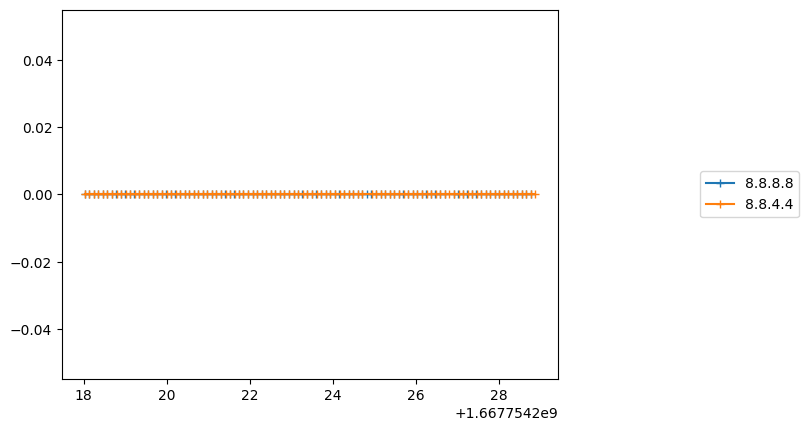

In [21]:
%matplotlib inline
ans.multiplot(lambda x, y: (y[IP].src, (y.time, y[IP].id)), plot_xy=True)

In [23]:
pkt = IP() / UDP() / DNS(qd=DNSQR())
print(repr(raw(pkt)))

b'E\x00\x00=\x00\x01\x00\x00@\x11|\xad\x7f\x00\x00\x01\x7f\x00\x00\x01\x005\x005\x00)\xb6\xd3\x00\x00\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x03www\x07example\x03com\x00\x00\x01\x00\x01'


In [24]:
print(pkt.summary())

IP / UDP / DNS Qry "b'www.example.com.'" 


In [25]:
hexdump(pkt)

0000  45 00 00 3D 00 01 00 00 40 11 7C AD 7F 00 00 01  E..=....@.|.....
0010  7F 00 00 01 00 35 00 35 00 29 B6 D3 00 00 01 00  .....5.5.)......
0020  00 01 00 00 00 00 00 00 03 77 77 77 07 65 78 61  .........www.exa
0030  6D 70 6C 65 03 63 6F 6D 00 00 01 00 01           mple.com.....


In [26]:
pkt.show()

###[ IP ]### 
  version   = 4
  ihl       = None
  tos       = 0x0
  len       = None
  id        = 1
  flags     = 
  frag      = 0
  ttl       = 64
  proto     = udp
  chksum    = None
  src       = 127.0.0.1
  dst       = 127.0.0.1
  \options   \
###[ UDP ]### 
     sport     = domain
     dport     = domain
     len       = None
     chksum    = None
###[ DNS ]### 
        id        = 0
        qr        = 0
        opcode    = QUERY
        aa        = 0
        tc        = 0
        rd        = 1
        ra        = 0
        z         = 0
        ad        = 0
        cd        = 0
        rcode     = ok
        qdcount   = 1
        ancount   = 0
        nscount   = 0
        arcount   = 0
        \qd        \
         |###[ DNS Question Record ]### 
         |  qname     = 'www.example.com.'
         |  qtype     = A
         |  qclass    = IN
        an        = None
        ns        = None
        ar        = None



FileNotFoundError: [WinError 2] Das System kann die angegebene Datei nicht finden

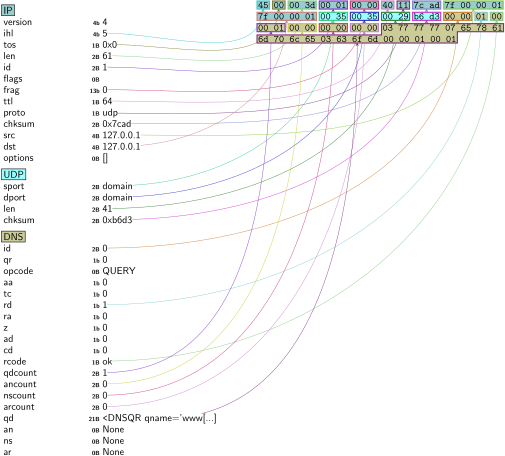

In [27]:
pkt.canvas_dump()

In [29]:
ans, unans = traceroute('www.secdev.org', maxttl=15)

Begin emission:
Finished sending 15 packets.

Received 18 packets, got 13 answers, remaining 2 packets
   217.25.178.5:tcp80 
1  192.168.0.1     11 
3  88.134.235.94   11 
4  145.254.3.192   11 
5  145.254.2.207   11 
6  184.104.231.45  11 
8  184.105.81.166  11 
9  184.104.207.166 11 
10 217.25.178.5    SA 
11 217.25.178.5    SA 
12 217.25.178.5    SA 
13 217.25.178.5    SA 
14 217.25.178.5    SA 
15 217.25.178.5    SA 


In [32]:
ans = sr(IP(dst=["scanme.nmap.org", "nmap.org"])/TCP(dport=[22, 80, 443, 31337]), timeout=3, verbose=False)[0]
ans.extend(sr(IP(dst=["scanme.nmap.org", "nmap.org"])/UDP(dport=53)/DNS(qd=DNSQR()), timeout=3, verbose=False)[0])
ans.make_table(lambda x, y: (x[IP].dst, x.sprintf('%IP.proto%/{TCP:%r,TCP.dport%}{UDP:%r,UDP.dport%}'), y.sprintf('{TCP:%TCP.flags%}{ICMP:%ICMP.type%}')))

          45.33.32.156 45.33.49.119 
tcp/22    SA           SA           
tcp/31337 SA           RA           
tcp/443   RA           SA           
tcp/80    SA           SA           
udp/53    dest-unreach -            


In [1]:
from scapy.all import *
from scapy.layers.http import HTTPRequest # import HTTP packet
from colorama import init, Fore
# initialize colorama
init()
# define colors
GREEN = Fore.GREEN
RED   = Fore.RED
RESET = Fore.RESET

In [2]:
def sniff_packets(iface=None):
    """
    Sniff 80 port packets with `iface`, if None (default), then the
    Scapy's default interface is used
    """
    if iface:
        # port 80 for http (generally)
        # `process_packet` is the callback
        sniff(filter="port 80", prn=process_packet, iface=iface, store=False)
    else:
        # sniff with default interface
        sniff(filter="port 80", prn=process_packet, store=False)

In [3]:
def process_packet(packet):
    """
    This function is executed whenever a packet is sniffed
    """
    if packet.haslayer(HTTPRequest):
        # if this packet is an HTTP Request
        # get the requested URL
        url = packet[HTTPRequest].Host.decode() + packet[HTTPRequest].Path.decode()
        # get the requester's IP Address
        ip = packet[IP].src
        # get the request method
        method = packet[HTTPRequest].Method.decode()
        print(f"\n{GREEN}[+] {ip} Requested {url} with {method}{RESET}")
        if show_raw and packet.haslayer(Raw) and method == "POST":
            # if show_raw flag is enabled, has raw data, and the requested method is "POST"
            # then show raw
            print(f"\n{RED}[*] Some useful Raw data: {packet[Raw].load}{RESET}")

In [12]:
IFACE_NAME="Intel(R) Ethernet Connection (2) I219-V"

fob = open("IP.txt","w")

def log(pkt):
        fob.write(
            f"{pkt[IP].src} -> {pkt[IP].dst} {pkt[IP].proto}\n"
        )

packets = sniff(
   iface=IFACE_NAME,
   filter="ip",
   prn=log
)

fob.close()
